In [1]:
%cd -q ../..
from collections import Counter, defaultdict
from pathlib import Path

import pandas as pd

from scotus_metalang.diachronic_analysis.authors import ORDERED_JUSTICES, SCDB_NAME_TO_JUSTICE

pd.set_option("display.max_columns", None)

In [2]:
scdb = pd.read_csv("data/scdb/SCDB_2023_01_justiceCentered_Docket.csv", encoding="cp1252")
scdb_86_onward = scdb[(scdb.term >= 1986) & (scdb.term <= 2019)]

def get_scdb_docket_numbers(docket_number):
    """Formats single CAP docket num into list of possible SCDB docket nums."""
    if docket_number == "141-orig":
        return ["22O141"]
    if "orig" in docket_number.lower():
        num = docket_number.split("-")[0]
        return [f"{num}, Orig.", f"No. {num}, Orig.", f"{num} ORIG"]
    else:
        return [docket_number]

def get_term(df, docket_numbers):
    return df[df["docket"].isin(docket_numbers)]["term"].iloc[0]

def get_expected_opinions(df, docket_numbers):
    return len(df[(df["docket"].isin(docket_numbers)) & (df["opinion"] == 2.0)])
def get_expected_opinion_authors(df, docket_numbers):
    result = []
    for scdb_author in df[(df["docket"].isin(docket_numbers)) & (scdb_86_onward["opinion"] == 2.0)]["justiceName"].values:
        result.append(SCDB_NAME_TO_JUSTICE[scdb_author])
    return result

In [3]:
get_expected_opinion_authors(scdb_86_onward, ["13-1433"])

['thomas', 'alito', 'sotomayor']

### Calculate opinion hit rate by author

In [7]:
# Gather opinions from both sources by docket number
cap_opinions_by_docket_num = defaultdict(list)
scdb_opinions_by_docket_num = {}
for opinion_filepath in Path("data/cap/known_authors").glob("*/*.json"):
    docket_number = opinion_filepath.stem
    author = opinion_filepath.parent.name
    cap_opinions_by_docket_num[docket_number].append(author)
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_opinions = get_expected_opinions(scdb_86_onward, scdb_docket_numbers)
    scdb_opinions_by_docket_num[docket_number] = expected_opinions

# Gather opinions by author
actual_opinions_by_author = Counter()
expected_opinions_by_author = Counter()
for docket_number, actual_authors in cap_opinions_by_docket_num.items():
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_authors = get_expected_opinion_authors(scdb_86_onward, scdb_docket_numbers)
    for author in actual_authors:
        actual_opinions_by_author[author] += 1
    # Union because there's at least one case where SCDB is missing an author
    expected_authors = set(expected_authors).union(set(actual_authors))
    for author in expected_authors:
        expected_opinions_by_author[author] += 1

# Compare CAP opinions to SCDB Expectations
for author in ORDERED_JUSTICES:
    actual_count = actual_opinions_by_author[author]
    hit_rate = actual_count / expected_opinions_by_author[author]
    print(author, f"{hit_rate:.03f}")

TypeError: only list-like objects are allowed to be passed to isin(), you passed a `str`

In [186]:
missing_by_year = defaultdict(Counter)
bad_sp
expected_by_year = defaultdict(Counter)
for docket_number, actual_authors in cap_opinions_by_docket_num.items():
    scdb_docket_numbers = get_scdb_docket_numbers(docket_number)
    expected_authors = get_expected_opinion_authors(scdb_86_onward, scdb_docket_numbers)
    term = get_term(scdb_86_onward, scdb_docket_numbers)
    #expected_authors = set(expected_authors).union(set(actual_authors))
    missing_authors = set(expected_authors) - set(actual_authors)
    for author in missing_authors:
        missing_by_year[term][author] += 1
    for author in expected_authors:
        expected_by_year[term][author] += 1

In [189]:
missing_by_year[2014]

Counter({'thomas': 16,
         'scalia': 16,
         'alito': 9,
         'roberts': 5,
         'sotomayor': 5,
         'ginsburg': 5,
         'breyer': 3,
         'kagan': 2,
         'kennedy': 1})

In [161]:
from matplotlib import pyplot as plt

In [166]:
missing_ratio_by_year

NameError: name 'missing_ratio_by_year' is not defined

In [173]:
sum(missing_by_year[2012])

46

In [187]:
missing_ratio_by_year = [sum(missing_by_year[y].values()) / sum(expected_by_year[y].values()) for y in sorted(missing_by_year)]


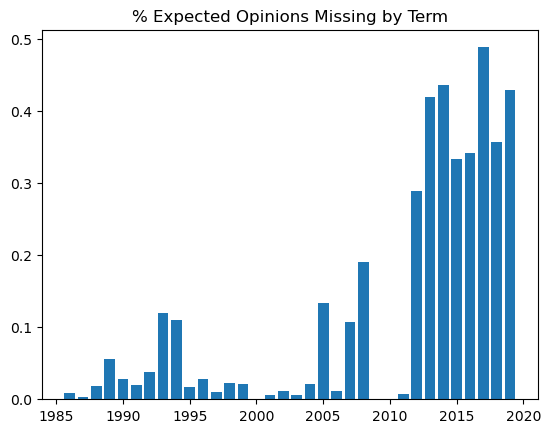

In [188]:
plt.bar(sorted(missing_by_year.keys()), missing_ratio_by_year)
plt.title("% Expected Opinions Missing by Term")
plt.show()

In [154]:
scdb_86_onward[scdb_86_onward["docket"].str.match("[0-9]*[-|–][0-9]*|[0-9]* ORIG|[0-9]*, Orig.|.*A-.*|na|.*A.*") == False]["docket"]

89737        126, ORIG.
89738        126, ORIG.
89739        126, ORIG.
89740        126, ORIG.
89741        126, ORIG.
89742        126, ORIG.
89743        126, ORIG.
89744        126, ORIG.
89745        126, ORIG.
91137    No. 137, Orig.
91138    No. 137, Orig.
91139    No. 137, Orig.
91140    No. 137, Orig.
91141    No. 137, Orig.
91142    No. 137, Orig.
91143    No. 137, Orig.
91144    No. 137, Orig.
92158    No. 142, Orig.
92159    No. 142, Orig.
92160    No. 142, Orig.
92161    No. 142, Orig.
92162    No. 142, Orig.
92163    No. 142, Orig.
92164    No. 142, Orig.
92165    No. 142, Orig.
92166    No. 142, Orig.
92167            22O141
92168            22O141
92169            22O141
92170            22O141
92171            22O141
92172            22O141
92173            22O141
92174            22O141
92175            22O141
Name: docket, dtype: object

In [135]:
scdb_86_onward[scdb_86_onward["caseName"].isin(["TEXAS v. NEW MEXICO AND COLORADO"])]

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,dateArgument,dateRearg,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,threeJudgeFdc,caseOrigin,caseOriginState,caseSource,caseSourceState,lcDisagreement,certReason,lcDisposition,lcDispositionDirection,declarationUncon,caseDisposition,caseDispositionUnusual,partyWinning,precedentAlteration,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes,justice,justiceName,vote,opinion,direction,majority,firstAgreement,secondAgreement
92167,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-01,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,111,JGRoberts,1.0,1.0,NaN,2.0,NaN,NaN
92168,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-02,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,106,AMKennedy,1.0,1.0,NaN,2.0,NaN,NaN
92169,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-03,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,108,CThomas,1.0,1.0,NaN,2.0,NaN,NaN
92170,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-04,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,109,RBGinsburg,1.0,1.0,NaN,2.0,NaN,NaN
92171,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-05,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,110,SGBreyer,1.0,1.0,NaN,2.0,NaN,NaN
92172,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-06,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,112,SAAlito,1.0,1.0,NaN,2.0,NaN,NaN
92173,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-07,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,113,SSotomayor,1.0,1.0,NaN,2.0,NaN,NaN
92174,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-08,3/5/2018,1,NaN,138 S. Ct. 954,200 L. Ed. 2d 235,2018 U.S. LEXIS 1518,2017,1706,Roberts,22O141,TEXAS v. NEW MEXICO AND COLORADO,1/8/2018,NaN,28.0,51.0,28.0,36.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,2.0,0.0,0.0,110030.0,11.0,3.0,NaN,3.0,NaN,1.0,130.0,NaN,115.0,111.0,1,9,0,114,EKagan,1.0,1.0,NaN,2.0,NaN,NaN
92175,2017-032,2017-032-01,2017-032-01-01,2017-032-01-01-01-09,3/5/2018,1,NaN,138 S. Ct. 954,200

In [41]:
total_missing = 0
total = 0
for docket_number, expectation in scdb_opinions_by_docket_num.items(
):
    num_missing = expectation - len(cap_opinions_by_docket_num[docket_number])
    if num_missing >= 0:
        total_missing += num_missing
    total += expectation

In [44]:
total_missing / (total_missing + total)

0.08518781006378455